**Disclaimer:** Please note that this entire script may take about 20 minutes to run completely. 

# 1. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import StandardScaler 

from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics.pairwise import cosine_similarity

from multiprocessing import Pool

#from kneed import KneeLocator #Install #Find the knee of the WCSS vs K plot
#from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 2. Import Data

For teaching team
Please change the location variable to your desired directory to read in hackaton files.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# please change your desired directory here
location = '/content/drive/My Drive/DSA3101 Group 9/data/'

Mounted at /content/drive


In [4]:
# run the mount drive below
# put the data folder on the root directory of your google drive
df_catinfo = pd.read_csv(location + 'DSA3101_Hackathon_Categories_Information.csv')
df_hackdata= pd.read_csv(location + 'DSA3101_Hackathon_Data.csv', parse_dates=['Date'])
df_paneldemo = pd.read_excel(location + 'DSA3101_Hackathon_Panelists_Demographics.xlsx')

In [5]:
df_paneldemo['Ethnic'] = df_paneldemo.Ethnicity.apply(lambda x: x.split(" ")[-1])

### Data Transformation

For K-Means Clustering (Customers).

Asides from calculating their monetary and frequency values, we will add in a new column that indicates on a daily basis, how many calories does each customer intake.

Below is a plot of the spread of calories across the various categories that we have. 

Text(0, 0.5, 'Calories/100g')

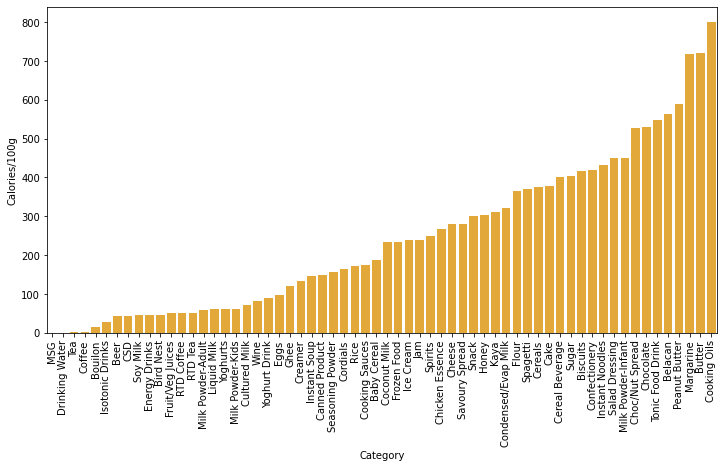

In [6]:
df = df_catinfo.sort_values(['Calories/100g']).reset_index(drop=True)
plt.figure(figsize=(12,6))
bar = sns.barplot(x=df.Category, y=df['Calories/100g'], color= '#FFB11E')
for item in bar.get_xticklabels():
    item.set_rotation(90)
plt.ylabel("Calories/100g")

In [7]:
''' Since there are zero values, in both Volume and Pack Size, we need to take that into account while 
multiplying in the next block of code. '''

df_hackdata.loc[(df_hackdata['Volume'] == 0) & (df_hackdata['Pack Size']== 0)]['Category'].unique()

array(['Coffee', 'MSG', 'Bouilon', 'Tea', 'Biscuits', 'Coconut Milk',
       'Chocolate', 'Yoghurts', 'Cereals', 'Tonic Food Drink', 'Snack',
       'Ice Cream', 'Cooking Sauces', 'Creamer', 'Confectionery'],
      dtype=object)

The end goal for the K-Means clustering by customer is to estimate the **average caloric consumption** of the customer/individual. Reason why BMI was not preferred over this method is that BMI levels itself give us limited information, and it would be better to perform K-Means on numeric values rather than ordinal figures. 

We have taken into account the following things:

1. Some categories may be high on caloric weightage, such as cooking oils (800 Calories/100g) but it's not reasonable to think that one would consume all 100g. However, this is not a concern, as the frequency of their purchase of the item would be indicative of how fast they finished consuming the items they have bought. Items that have a smaller serving size (like cooking oil) will be consumed slower.
2. Calories/100g will then be multiplied by volume or pack size.
3. We will not penalise customers for buying large volume of goods if they have a large family. Calories computed will be divided by number of household members. 
4. Caloric figures computed are not to be taken at face value, they will be scaled according to the distribution, especially when being used in K-Means. 

Assumptions made:
1. These are the only grocery transactions they have made, and hence, it is reasonable to liken the average calories consumed per day to what they may actually consume typically. 


In [8]:
df_hackdata2 = df_hackdata.merge(df_catinfo, left_on='Category', right_on = 'Category')

def convert(x):
    if x['Volume'] == 0 & x['Pack Size'] == 0: 
        y = x['Calories/100g']
    elif x['Volume'] == 0:
        y = x['Calories/100g']*x['Pack Size']
    else:
        y = x['Calories/100g']*x['Volume']
    return(y) 
        
df_hackdata2['Volume*Calories'] = df_hackdata2.apply(lambda row: convert(row),axis=1)

df_hackdata2 = df_hackdata2.groupby(['Panel ID', 'Date'])['Volume*Calories'].\
                            agg('sum').\
                            reset_index().\
                            groupby('Panel ID')['Volume*Calories'].\
                            agg('mean').reset_index()

df_hackdata2.head()

,Panel ID,Volume*Calories
0,Panel 101011101,3134.954128
1,Panel 101016101,2670.116901
2,Panel 101019101,4745.492810
3,Panel 101024101,3223.792157
4,Panel 105009103,2360.576282


In [9]:
df_paneldemo['#HH'].unique()

array(['1-3 Member HH', '4 Member HH', '7+ Member HH', '5 Member HH',
       '6 Member HH'], dtype=object)

In [10]:
df_hackdata3 = df_hackdata2.\
            merge(df_paneldemo,left_on = 'Panel ID', right_on = 'ID')[['Panel ID', 'Volume*Calories', '#HH', 'BMI']]

segt_map = {
    r'1-3 Member HH' : 2,
    r'4 Member HH': 4,
    r'7\+ Member HH': 7,
    r'5 Member HH': 5,
    r'6 Member HH': 6
}

# Attempt to generate Average Calories by dividing number of household members

df_hackdata3['Members'] = df_hackdata3['#HH']
df_hackdata3['Members'] = df_hackdata3['Members'].replace(segt_map, regex=True).astype(int)
df_hackdata3['AvgCalories'] = df_hackdata3['Volume*Calories'] / df_hackdata3['Members']
df_hackdata3.head()

,Panel ID,Volume*Calories,#HH,BMI,Members,AvgCalories
0,Panel 101011101,3134.954128,1-3 Member HH,Obese,2,1567.477064
1,Panel 101016101,2670.116901,1-3 Member HH,Healthy,2,1335.058451
2,Panel 101019101,4745.492810,4 Member HH,Obese,4,1186.373203
3,Panel 101024101,3223.792157,1-3 Member HH,Over Weight,2,1611.896078
4,Panel 105009103,2360.576282,1-3 Member HH,Over Weight,2,1180.288141


Earlier, we had said that calories will be divided by the number of members in the household, however that is a bit unfair as the larger families get heavily penalised and the mean for 2 household members vs 7 household members becomes highly different.

In [11]:
df_hackdata3.groupby('Members')['Volume*Calories'].describe()

,count,mean,std,min,25%,50%,75%,max
Members,,,,,,,,
2,918.0,2784.729051,1885.206940,180.164220,1593.843323,2410.353581,3465.543065,18896.292308
4,738.0,3272.616762,2075.991413,283.133333,1825.060049,2816.389667,4139.785549,14840.510714
5,726.0,3756.911306,2348.257241,353.550000,2263.831250,3320.173113,4666.989753,30225.408824
6,428.0,4349.516879,2980.315916,257.742857,2613.305405,3679.153511,5229.842586,25967.290000
7,426.0,4530.150014,2799.853476,434.150000,2796.598381,3949.422795,5496.034732,22083.000000


In [12]:
df_hackdata3.groupby('BMI')['AvgCalories'].describe()

,count,mean,std,min,25%,50%,75%,max
BMI,,,,,,,,
Healthy,1243.0,884.888273,655.106701,68.234568,484.818611,723.048529,1082.634307,6713.850000
Obese,449.0,1124.697602,930.168927,85.456250,563.676900,876.025000,1392.719545,9448.146154
Over Weight,796.0,990.568172,673.157248,71.637143,558.560825,811.071056,1230.580766,5774.365169
Under Weight,748.0,828.946339,650.677119,42.957143,430.293393,648.911987,1029.797167,6227.950000


To cope with this issue, we can instead, choose to standardize the values within each group (#members), so that numbers can be comparable across all the groups.

In [13]:
df_hackdata3['AvgCalories'] = df_hackdata3.groupby('Members')['Volume*Calories'].\
                                transform(lambda x: (x - x.mean()) / x.std())

df_hackdata3.groupby('BMI')['AvgCalories'].describe()

,count,mean,std,min,25%,50%,75%,max
BMI,,,,,,,,
Healthy,1243.0,-0.100421,0.932007,-1.449314,-0.658542,-0.288038,0.184592,11.271549
Obese,449.0,0.328797,1.280575,-1.411755,-0.513660,0.043966,0.793484,8.546310
Over Weight,796.0,0.081573,0.931227,-1.438893,-0.567947,-0.108419,0.458479,7.253517
Under Weight,748.0,-0.117297,0.933831,-1.462934,-0.756380,-0.299911,0.296029,6.731744


If one may see the table & plot below, the mean numbers seem indicative of the respective BMI levels i.e

- Underweight --> lowest caloric values
- Healthy --> second lowest
- Overweight --> second highest
- Obese --> highest 

There are overlap caloric values across the groups, but it is sufficient that the quarterly percentiles are indicative of each group.


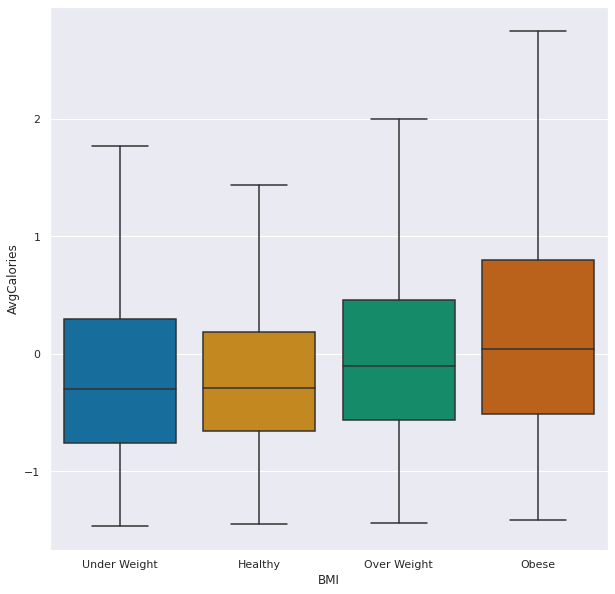

In [14]:
plt.figure(figsize=(10,10))
sns.set(font_scale = 1)
sns.boxplot(y= "AvgCalories", x='BMI', data=df_hackdata3, palette="colorblind",showfliers=False, 
            order = ["Under Weight", "Healthy","Over Weight","Obese"])

In [15]:
df_hackdata3.groupby('BMI').describe()['AvgCalories']

,count,mean,std,min,25%,50%,75%,max
BMI,,,,,,,,
Healthy,1243.0,-0.100421,0.932007,-1.449314,-0.658542,-0.288038,0.184592,11.271549
Obese,449.0,0.328797,1.280575,-1.411755,-0.513660,0.043966,0.793484,8.546310
Over Weight,796.0,0.081573,0.931227,-1.438893,-0.567947,-0.108419,0.458479,7.253517
Under Weight,748.0,-0.117297,0.933831,-1.462934,-0.756380,-0.299911,0.296029,6.731744


In [16]:
# Here, we will introduce monetary and frequency spendings as additional features to cluster the customers by.

df_hackdata4 = df_hackdata.groupby('Panel ID').agg({'Panel ID': lambda x: len(x),
                                                    'Spend': lambda x : x.sum()/len(x)} )

df_hackdata4.rename(columns={'Panel ID':'Frequency', 'Spend':'Monetary'},inplace=True)
df_hackdata4 = df_hackdata4.reset_index()

df_hackdata4 = df_hackdata4.merge(df_hackdata3,left_on = 'Panel ID', 
                   right_on = 'Panel ID')[['Panel ID', 'Frequency', 'Monetary', 'AvgCalories']]
df_hackdata4.head()

,Panel ID,Frequency,Monetary,AvgCalories
0,Panel 101011101,404,9.658911,0.185775
1,Panel 101016101,326,5.792025,-0.060796
2,Panel 101019101,1730,4.238902,0.709481
3,Panel 101024101,1004,5.966833,0.232899
4,Panel 105009103,1273,3.730636,-0.224990


# 2. K-Means Clustering (Customers)

In this section, we will use K-Means Clustering on transaction data as well as the categories data to do clustering based Caloric Consumption levels, Frequency and Monetary levels. This will eventually be fed into the reccomendation engine.

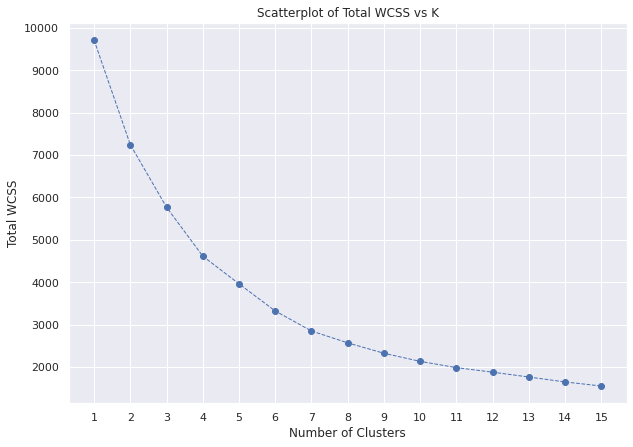

In [25]:
dataarray = df_hackdata4.drop(columns= ['Panel ID']).to_numpy()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray)

wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")
kl.elbow

NameError: ignored

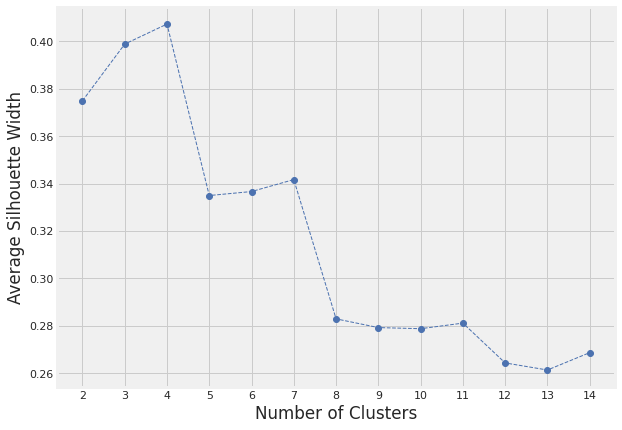

In [26]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)
    
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### 6 clusters

Since the elbow suggests 6, we can try 6 clusters first. 

In [27]:
kmeans6 = KMeans(init="random",n_clusters = 6, n_init = 10, max_iter = 300, random_state = 42)
kmeans6.fit(scaled_features)
clustergroups6 = kmeans6.labels_

model = KMeans(6, random_state=42)
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
silhouette_visualizer(model, scaled_features, colors='yellowbrick')
print("For n_clusters = 6, The average silhouette_score is: " + str(silhouette_score(scaled_features, model.labels_,metric = 'euclidean')))

NameError: ignored

<Figure size 720x504 with 0 Axes>

In [28]:
model_6 = df_hackdata4.copy()
model_6['Clusters'] = pd.DataFrame(clustergroups6)
model_6.groupby('Clusters').mean()

,Frequency,Monetary,AvgCalories
Clusters,,,
0,223.028070,22.422382,-0.379397
1,260.013043,13.544212,2.360978
2,198.044616,9.423401,-0.431600
3,707.592090,9.212476,0.172326
4,74.214286,75.196511,-0.444795
5,1663.028369,7.140327,1.023704


In [ ]:
df = df_hackdata.merge(model_6, left_on = 'Panel ID', right_on = 'Panel ID')
df.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend,Frequency,Monetary,AvgCalories,Clusters
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5,404,9.658911,0.185775,3
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8,404,9.658911,0.185775,3
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2,404,9.658911,0.185775,3
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3,404,9.658911,0.185775,3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6,404,9.658911,0.185775,3


In [ ]:
df2 = df.groupby(["Clusters", "Category"]).size().reset_index(name="Count").\
                                    sort_values(by=["Clusters", "Count"], ascending=False)
df2.head()

,Clusters,Category,Count
305,5,Biscuits,17510
353,5,Snack,16467
327,5,Eggs,13460
335,5,Instant Noodles,13202
322,5,Cooking Sauces,12234


### 5 clusters

Since 6 clusters has a rather low silhouette score, as well as one unnoticeably tiny cluster, which may not be quite significant, we would like to try 5 clusters instead. 

In [ ]:
kmeans5 = KMeans(init="random",n_clusters = 5, n_init = 10, max_iter = 300, random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_

# Clustercenters6 = pd.DataFrame(kmeans6.cluster_centers_) #Dataframe of cluster centers
# Clustercenters6.rename(columns={0: "Frequency", 1: "Monetary", 2: "AvgCalories"},inplace=True)
# Clustercenters6.index.name = "Clusters"

# Clustercenters6
model = KMeans(5, random_state=42)
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
silhouette_visualizer(model, scaled_features, colors='yellowbrick')
print("For n_clusters = 5, The average silhouette_score is: " + str(silhouette_score(scaled_features, model.labels_,metric = 'euclidean')))

NameError: ignored

<Figure size 720x504 with 0 Axes>

In [ ]:
model_5 = df_hackdata4.copy()
model_5['Clusters'] = pd.DataFrame(clustergroups5)
model_5.groupby('Clusters').mean()

,Frequency,Monetary,AvgCalories
Clusters,,,
0,721.227429,9.243356,0.152667
1,202.099356,10.285764,-0.432122
2,1689.947368,7.116606,1.060481
3,266.380392,13.422275,2.231584
4,161.720721,35.582385,-0.351982


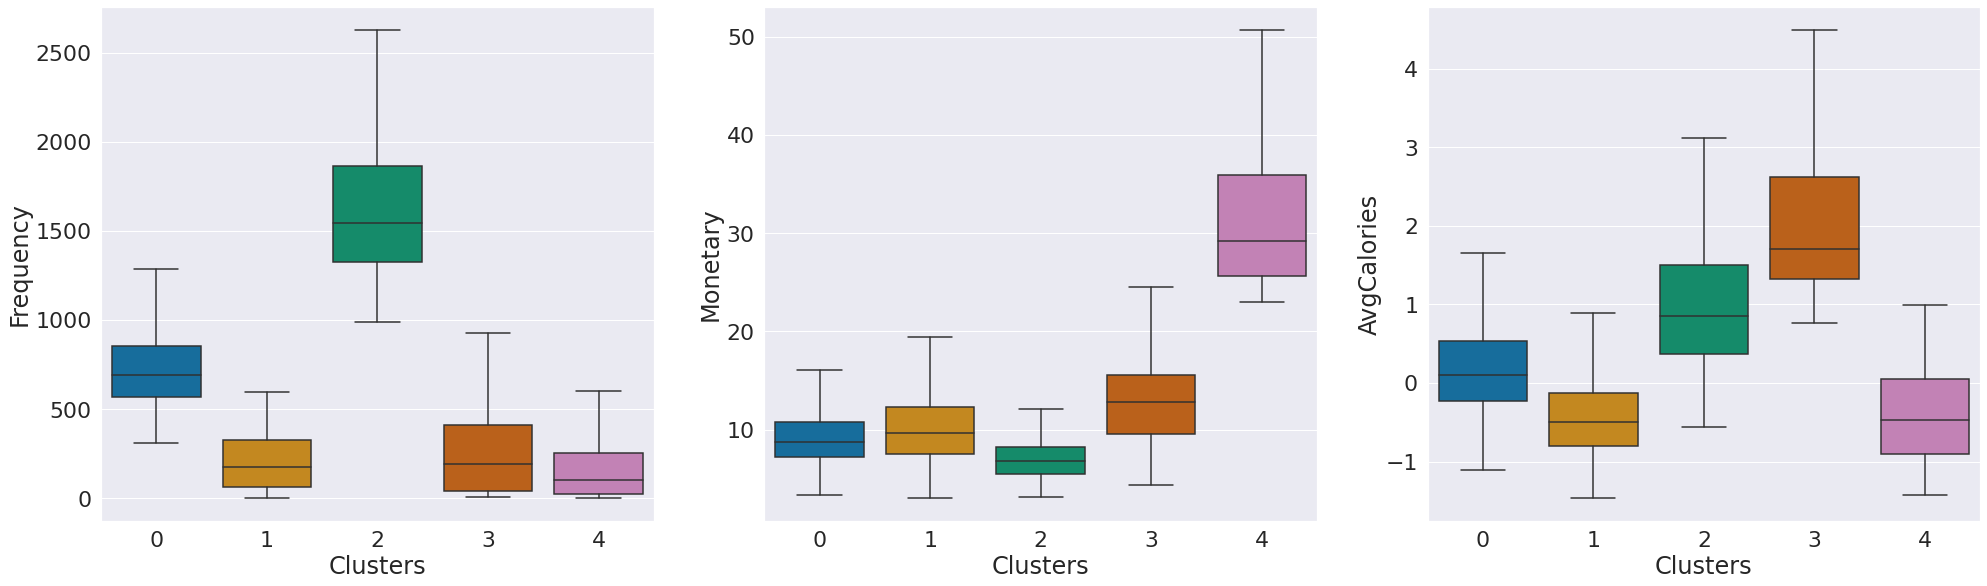

In [ ]:
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(1,4):
    plt.subplot(3,3,i)
    sns.boxplot(y=model_5.columns[i], x='Clusters', data=model_5, palette="colorblind",showfliers=False)

Since both 5 and 6 clusters have similar silhouette scores, and clusters formed with 6-way splitting causes signficantly small cluster groups (you may refer to the cluster 2), we have deemed 6 clusters to be unnecessary. 

We shall focus our reccomendation engine on 5 clusters instead of 6. 
Before doing so, let us take a look at the ANOVA values for determining if the features, _caloric consumption, frequency_ and _monetary values_ are significant for the 5 cluster K-Means model.

The p values are all less than 0.05, proving them to be significant features to carry out K-Means clustering on.

In [ ]:
#perform N-way ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

def clustereval(data,sig):
    eval = []
    cols = list(data.columns)[:-1]
    for c in cols:
        model = ols(c +' ~ C(Clusters)', data=data).fit()
        pval = sm.stats.anova_lm(model).iloc[0,4]
        print(c + " :")
        print("P-Value : " + str(pval))
        print("Significant at "+ str(sig) +": " + str(pval < sig))
        print()
        
clustereval(model_5.drop(columns = ['Panel ID']),0.05)

# 3. Recommender Engines

In [18]:
spending_df = df_hackdata.copy()
spending_df["Panel ID"]=spending_df["Panel ID"].apply(lambda x:x.split(" ")[-1])
spending_df

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,101011101,2017-07-02,CSD,1,1.5,1.5
1,101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,101011101,2017-07-02,Chocolate,1,0.2,6.6
...,...,...,...,...,...,...
1318019,801912801,2020-02-23,MSG,1,0.1,2.2
1318020,801912801,2020-02-23,Eggs,1,30.0,8.4
1318021,801912801,2020-02-23,Ice Cream,1,1.5,8.0
1318022,801912801,2020-02-23,Cooking Sauces,1,0.7,4.8


Group by ID and Category, the result will be the total amount of money that each customer spending on our store during these three years.

In [19]:
group_df=spending_df.groupby(["Panel ID","Category"])
group_df.size()
sum_grp=group_df.sum()
sum_grp=sum_grp.rename(columns={'Spend':'Total Spend'})
sum_grp=sum_grp.drop(["Pack Size","Volume"], axis=1)
sum_df=sum_grp.reset_index()
sum_df

,Panel ID,Category,Total Spend
0,101011101,Biscuits,106.5
1,101011101,Bouilon,15.4
2,101011101,Butter,45.4
3,101011101,CSD,94.8
4,101011101,Cake,15.7
...,...,...,...
97133,801912801,Ice Cream,8.0
97134,801912801,Liquid Milk,7.3
97135,801912801,MSG,4.4
97136,801912801,Rice,53.5


Find names of all distinct categories.

In [34]:
cate_list=sum_df["Category"].unique().tolist()
cate_list

['Biscuits',
 'Bouilon',
 'Butter',
 'CSD',
 'Cake',
 'Canned Product',
 'Cereal Beverage',
 'Cereals',
 'Cheese',
 'Choc/Nut Spread',
 'Chocolate',
 'Coconut Milk',
 'Coffee',
 'Condensed/Evap Milk',
 'Cooking Oils',
 'Cooking Sauces',
 'Cordials',
 'Cultured Milk',
 'Drinking Water',
 'Eggs',
 'Flour',
 'Frozen Food',
 'Fruit/Veg Juices',
 'Ice Cream',
 'Instant Noodles',
 'Isotonic Drinks',
 'Jam',
 'Liquid Milk',
 'MSG',
 'Margarine',
 'Milk Powder-Adult',
 'Peanut Butter',
 'RTD Tea',
 'Rice',
 'Salad Dressing',
 'Seasoning Powder',
 'Snack',
 'Soy Milk',
 'Spagetti',
 'Sugar',
 'Tea',
 'Tonic Food Drink',
 'Belacan',
 'Kaya',
 'Yoghurt Drink',
 'Confectionery',
 'Honey',
 'Instant Soup',
 'RTD Coffee',
 'Savoury Spread',
 'Yoghurts',
 'Milk Powder-Kids',
 'Ghee',
 'Baby Cereal',
 'Milk Powder-Infant',
 'Bird Nest',
 'Energy Drinks',
 'Beer',
 'Chicken Essence',
 'Wine',
 'Creamer',
 'Spirits']

## Preprocessing: Pivot table

Since we have all records of the money for each customer spending on each products, we can switch to a new pivot table so the column names are categoies and Panel ID is the table index. 


In [21]:
pivot_df = sum_df.pivot(index='Panel ID', columns='Category', values='Total Spend')
pivot_df.fillna(0,inplace=True)
pivot_df.head()

Category,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101011101,0.0,0.0,0.0,0.0,106.5,15.4,45.4,94.8,15.7,68.4,19.2,71.5,27.5,0.0,9.8,41.9,186.8,80.7,48.1,0.0,391.0,127.2,65.5,0.0,23.9,103.0,98.5,0.0,220.9,43.1,32.3,0.0,0.0,9.5,60.6,0.0,1.4,9.0,0.0,29.7,4.0,63.7,58.9,0.0,0.0,11.6,0.0,1.8,953.7,8.5,0.0,62.8,41.9,10.6,3.1,0.0,578.5,26.4,29.4,0.0,0.0,0.0
101016101,0.0,0.0,0.0,0.0,75.3,38.5,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,10.0,0.0,0.0,4.7,124.1,0.0,214.8,197.8,16.7,0.0,3.8,0.0,49.7,0.0,44.4,15.3,0.0,0.0,0.0,0.0,26.6,0.0,0.0,0.0,0.0,30.2,0.0,32.6,75.5,0.0,0.0,0.0,0.0,0.0,545.6,6.5,0.0,33.3,2.1,0.0,0.0,0.0,213.9,6.0,114.6,0.0,0.0,0.0
101019101,0.0,0.0,15.5,0.0,134.2,0.0,0.0,17.2,4.9,159.6,0.0,15.7,0.0,0.0,0.0,21.3,389.4,1620.2,131.8,0.0,238.0,36.1,91.8,0.0,70.1,0.0,792.5,0.0,12.5,11.8,5.5,0.0,0.0,20.0,364.7,0.0,33.5,0.0,3.0,3.4,20.7,10.6,0.0,0.0,0.0,4.1,0.0,1.0,1386.9,0.0,0.0,215.2,27.2,5.0,0.0,0.0,862.6,16.5,574.9,0.0,15.9,0.0
101024101,0.0,0.0,0.0,0.0,271.0,11.5,0.0,82.4,29.7,425.4,44.3,5.7,101.9,0.0,0.0,9.0,0.0,311.1,0.0,28.3,312.4,128.9,0.0,0.0,218.0,0.0,392.9,0.0,66.3,1127.6,57.2,0.0,15.0,33.7,456.2,4.3,93.8,0.0,5.0,37.0,38.6,52.6,0.0,0.0,0.0,10.0,29.9,77.5,554.7,32.5,6.2,7.0,348.7,76.2,50.2,0.0,36.3,53.6,285.8,0.0,57.3,5.0
105009103,0.0,0.0,0.0,0.0,316.6,24.4,0.0,0.0,2.6,430.3,111.6,0.0,0.0,0.0,0.0,0.0,0.0,380.4,0.0,11.0,387.5,197.3,41.8,0.0,0.0,12.5,489.9,0.0,0.0,0.0,0.0,0.0,0.0,45.6,57.2,0.0,24.0,0.0,0.0,0.0,0.0,0.0,248.3,0.0,0.0,0.0,0.0,0.0,415.4,0.0,0.0,664.3,0.0,20.2,0.0,0.0,39.8,2.6,825.8,0.0,0.0,0.0


From the describe(), there are many products which only few customers have bought, so the revenus could be increased by recommending certain products toward targeted customers.

In [22]:
pivot_df.describe() 

Category,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
count,3236.00000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.00000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000
mean,4.80618,49.489648,3.427101,5.695983,201.731304,22.903461,24.207602,23.947311,31.362361,85.661434,48.245179,26.049011,25.480810,15.049660,9.508158,37.754512,40.934456,128.921106,121.439215,11.198702,234.213041,128.427194,40.423331,1.96060,36.353214,16.591069,242.582417,2.199506,50.567862,159.738844,26.444129,8.170797,15.879419,52.332417,116.956366,5.191904,32.337454,6.413906,7.588350,100.966718,7.303708,23.381644,151.806428,55.541131,315.525989,18.803925,3.947868,12.001885,538.778399,14.369561,4.204295,44.195735,93.869036,12.592367,11.377194,10.499042,126.605995,45.648331,205.677256,8.135816,14.004821,13.286743
std,34.81739,423.781008,14.155805,63.663779,247.994288,43.243568,65.028203,60.038557,104.131299,153.436276,130.221378,63.488180,69.888843,86.720239,33.152959,97.234492,107.382076,222.417976,214.902545,30.828395,251.277921,155.170286,81.567319,16.24347,96.220003,81.387095,283.266851,29.044322,81.141849,272.775311,67.639767,46.488873,80.151975,101.961514,151.938212,20.927269,79.195220,24.052139,29.156392,208.625198,23.043737,43.899313,399.676091,276.139795,951.926999,43.720845,22.177659,40.805989,574.586161,28.569103,17.303055,93.151230,171.912122,38.372878,25.079455,231.296506,196.881185,84.677675,282.589558,111.152135,58.463960,46.632249
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,30.775000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.900000,5.500000,0.000000,42.875000,20.900000,0.000000,0.00000,0.000000,0.000000,30.675000,0.000000,3.575000,0.000000,0.000000,0.000000,0.000000,0.000000,14.775000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,102.850000,0.000000,0.000000,0.000000,3.100000,0.000000,0.000000,0.000000,10.800000,0.000000,19.375000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,117.550000,5.500000,0.000000,2.500000,0.000000,29.950000,7.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.900000,40.350000,36.350000,0

In [23]:
model_6

NameError: ignored

In [ ]:
# 3D scattered plot (runnable only on Jupyter)
fig = px.scatter_3d(model_6, 
                    x='Frequency', 
                    y='Monetary', 
                    z='AvgCalories',
                    color='Clusters', 
                    size_max=18,
              symbol='Clusters', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## Recommendation based on 6 clusters

In [29]:
cluster6_df  = model_6.loc[:, ['Panel ID', 'Clusters']]
cluster6_df["Panel ID"] = cluster6_df["Panel ID"].apply(lambda x:x.split(" ")[-1])

In [30]:
pivot_df3 = pivot_df.copy().reset_index()
pivot_df4 = pd.merge(pivot_df3, cluster6_df, how='left', on='Panel ID')
pivot_df4.head()

,Panel ID,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,Clusters
0,101011101,0.0,0.0,0.0,0.0,106.5,15.4,45.4,94.8,15.7,68.4,19.2,71.5,27.5,0.0,9.8,41.9,186.8,80.7,48.1,0.0,391.0,127.2,65.5,0.0,23.9,103.0,98.5,0.0,220.9,43.1,32.3,0.0,0.0,9.5,60.6,0.0,1.4,9.0,0.0,29.7,4.0,63.7,58.9,0.0,0.0,11.6,0.0,1.8,953.7,8.5,0.0,62.8,41.9,10.6,3.1,0.0,578.5,26.4,29.4,0.0,0.0,0.0,3
1,101016101,0.0,0.0,0.0,0.0,75.3,38.5,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,10.0,0.0,0.0,4.7,124.1,0.0,214.8,197.8,16.7,0.0,3.8,0.0,49.7,0.0,44.4,15.3,0.0,0.0,0.0,0.0,26.6,0.0,0.0,0.0,0.0,30.2,0.0,32.6,75.5,0.0,0.0,0.0,0.0,0.0,545.6,6.5,0.0,33.3,2.1,0.0,0.0,0.0,213.9,6.0,114.6,0.0,0.0,0.0,2
2,101019101,0.0,0.0,15.5,0.0,134.2,0.0,0.0,17.2,4.9,159.6,0.0,15.7,0.0,0.0,0.0,21.3,389.4,1620.2,131.8,0.0,238.0,36.1,91.8,0.0,70.1,0.0,792.5,0.0,12.5,11.8,5.5,0.0,0.0,20.0,364.7,0.0,33.5,0.0,3.0,3.4,20.7,10.6,0.0,0.0,0.0,4.1,0.0,1.0,1386.9,0.0,0.0,215.2,27.2,5.0,0.0,0.0,862.6,16.5,574.9,0.0,15.9,0.0,5
3,101024101,0.0,0.0,0.0,0.0,271.0,11.5,0.0,82.4,29.7,425.4,44.3,5.7,101.9,0.0,0.0,9.0,0.0,311.1,0.0,28.3,312.4,128.9,0.0,0.0,218.0,0.0,392.9,0.0,66.3,1127.6,57.2,0.0,15.0,33.7,456.2,4.3,93.8,0.0,5.0,37.0,38.6,52.6,0.0,0.0,0.0,10.0,29.9,77.5,554.7,32.5,6.2,7.0,348.7,76.2,50.2,0.0,36.3,53.6,285.8,0.0,57.3,5.0,3
4,105009103,0.0,0.0,0.0,0.0,316.6,24.4,0.0,0.0,2.6,430.3,111.6,0.0,0.0,0.0,0.0,0.0,0.0,380.4,0.0,11.0,387.5,197.3,41.8,0.0,0.0,12.5,489.9,0.0,0.0,0.0,0.0,0.0,0.0,45.6,57.2,0.0,24.0,0.0,0.0,0.0,0.0,0.0,248.3,0.0,0.0,0.0,0.0,0.0,415.4,0.0,0.0,664.3,0.0,20.2,0.0,0.0,39.8,2.6,825.8,0.0,0.0,0.0,5


In [31]:
add1_df = pivot_df4.copy()
for i in cate_list:
    add1_df[i] = add1_df[i].apply(lambda x:x+1)
add1_df.head()
add1_df=add1_df.set_index(["Panel ID"])
add1_df.head()

,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,Clusters
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101011101,1.0,1.0,1.0,1.0,107.5,16.4,46.4,95.8,16.7,69.4,20.2,72.5,28.5,1.0,10.8,42.9,187.8,81.7,49.1,1.0,392.0,128.2,66.5,1.0,24.9,104.0,99.5,1.0,221.9,44.1,33.3,1.0,1.0,10.5,61.6,1.0,2.4,10.0,1.0,30.7,5.0,64.7,59.9,1.0,1.0,12.6,1.0,2.8,954.7,9.5,1.0,63.8,42.9,11.6,4.1,1.0,579.5,27.4,30.4,1.0,1.0,1.0,3
101016101,1.0,1.0,1.0,1.0,76.3,39.5,1.0,1.0,1.0,1.0,1.0,7.2,1.0,1.0,11.0,1.0,1.0,5.7,125.1,1.0,215.8,198.8,17.7,1.0,4.8,1.0,50.7,1.0,45.4,16.3,1.0,1.0,1.0,1.0,27.6,1.0,1.0,1.0,1.0,31.2,1.0,33.6,76.5,1.0,1.0,1.0,1.0,1.0,546.6,7.5,1.0,34.3,3.1,1.0,1.0,1.0,214.9,7.0,115.6,1.0,1.0,1.0,2
101019101,1.0,1.0,16.5,1.0,135.2,1.0,1.0,18.2,5.9,160.6,1.0,16.7,1.0,1.0,1.0,22.3,390.4,1621.2,132.8,1.0,239.0,37.1,92.8,1.0,71.1,1.0,793.5,1.0,13.5,12.8,6.5,1.0,1.0,21.0,365.7,1.0,34.5,1.0,4.0,4.4,21.7,11.6,1.0,1.0,1.0,5.1,1.0,2.0,1387.9,1.0,1.0,216.2,28.2,6.0,1.0,1.0,863.6,17.5,575.9,1.0,16.9,1.0,5
101024101,1.0,1.0,1.0,1.0,272.0,12.5,1.0,83.4,30.7,426.4,45.3,6.7,102.9,1.0,1.0,10.0,1.0,312.1,1.0,29.3,313.4,129.9,1.0,1.0,219.0,1.0,393.9,1.0,67.3,1128.6,58.2,1.0,16.0,34.7,457.2,5.3,94.8,1.0,6.0,38.0,39.6,53.6,1.0,1.0,1.0,11.0,30.9,78.5,555.7,33.5,7.2,8.0,349.7,77.2,51.2,1.0,37.3,54.6,286.8,1.0,58.3,6.0,3
105009103,1.0,1.0,1.0,1.0,317.6,25.4,1.0,1.0,3.6,431.3,112.6,1.0,1.0,1.0,1.0,1.0,1.0,381.4,1.0,12.0,388.5,198.3,42.8,1.0,1.0,13.5,490.9,1.0,1.0,1.0,1.0,1.0,1.0,46.6,58.2,1.0,25.0,1.0,1.0,1.0,1.0,1.0,249.3,1.0,1.0,1.0,1.0,1.0,416.4,1.0,1.0,665.3,1.0,21.2,1.0,1.0,40.8,3.6,826.8,1.0,1.0,1.0,5


In [33]:
add1_df.shape

(3236, 63)

In [ ]:
add1_df.to_csv("add1.csv")

In [ ]:
def recommend_profile_6(panelid):
    cluster = int(add1_df.loc[panelid,"Clusters":])
    df = add1_df[add1_df["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    cosinelist = []
    uservec = df.loc[panelid,:].to_numpy()
    indexofuser = df.index.get_loc(panelid)
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave

In [ ]:
def recommend_list_6(id):
    ave = recommend_profile_6(id).tolist()
    
    cluster = int(add1_df.loc[id,"Clusters":])
    df = add1_df[add1_df["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    uservec = df.loc[id,:].to_numpy().tolist()
    
    recommend=[]
    for i in range(len(cate_list)):
        if uservec[i]==1 and ave[i]!=1:
            recommend.append([cate_list[i], ave[i]-1])
    return sorted(recommend, key = lambda x:x[1],reverse=True)

In [ ]:
recommend_profile_6('136083101')

array([  26.84,  736.3 ,    2.5 ,    1.  ,  172.24,    1.42,    6.54,
         23.52,   30.28,   41.24,   15.21,   11.82,   61.81,   73.69,
          1.  ,  150.27,    2.88,   43.98,   13.27,    6.35,  224.3 ,
         48.82,    6.72,    1.  ,   20.8 ,    1.06,   64.88,    1.  ,
          9.21,   67.18,    5.65,    1.  ,   20.92,   24.42,  111.45,
         11.55,   52.36,    1.  ,    1.  ,   30.63,   27.69,    5.84,
        260.59,  268.92, 2088.41,    4.99,    5.35,    1.66,  190.15,
          5.95,    1.  ,    2.65,   19.95,    1.35,    4.54,  120.28,
         10.32,   14.75,   48.76,   10.99,    7.88,    7.12])

In [ ]:
recommend_list_6('105021106')

In [ ]:
def per_profit(panelid):
    cluster = int(add1_df.loc[panelid,"Clusters":])
    df = add1_df[add1_df["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    uservec = df.loc[panelid,:].to_numpy()
    ave = recommend_profile_6(panelid)
    profit=[]
    for i in range(len(uservec)):
        if uservec[i] == 1:
            profit.append(round(ave[i]-1,1))
        else:
            profit.append(0)
    sum(profit)
    return sum(profit)

In [ ]:
recommend_profile_6('105021106')

array([   4.23,   11.04,   27.45,    1.5 ,   79.39,   26.84,   11.47,
         12.88,    2.8 ,   74.71,    6.24,    6.54,    1.  ,    2.57,
          4.64,    6.38,   18.55,  236.77,  147.22,    3.01,  345.59,
        157.98,   69.84,    1.  ,   15.88,    8.63,  396.2 ,    1.82,
         68.92,   56.87,    9.46,    1.  ,    6.  ,   14.46,   94.72,
          3.02,   17.71,    2.38,    3.06,   10.84,   23.6 ,   18.16,
        106.88,    3.6 ,   16.2 ,    6.98,    2.  ,    3.6 , 1186.34,
          5.04,    1.6 ,   56.3 ,   26.56,    2.74,    2.71,    1.  ,
        213.29,   31.6 ,  145.43,    1.  ,    4.94,    2.7 ])

In [ ]:
##Warning: this part is really time-consuming!
index_list = add1_df.index.to_list()
profit_list = []
revenue = 0
for i in index_list:
    p = per_profit(i)
    profit_list.append([i,p])
    revenue+=p
quarter_increse = revenue/12

## Recommendation based on 5 clusters

In [ ]:
cluster5_df  = model_5.loc[:, ['Panel ID', 'Clusters']]
cluster5_df["Panel ID"] = cluster5_df["Panel ID"].apply(lambda x:x.split(" ")[-1])

Merging clusters into pivot table, now we have all informations includeing how much money customer spends on the product, and which cluster the customer belongs to.

In [ ]:
pivot_df5 = pivot_df.copy().reset_index()
pivot_df5 = pd.merge(pivot_df5, cluster5_df, how='left', on='Panel ID')
pivot_df5.head()

,Panel ID,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,Clusters
0,101011101,0.0,0.0,0.0,0.0,106.5,15.4,45.4,94.8,15.7,68.4,19.2,71.5,27.5,0.0,9.8,41.9,186.8,80.7,48.1,0.0,391.0,127.2,65.5,0.0,23.9,103.0,98.5,0.0,220.9,43.1,32.3,0.0,0.0,9.5,60.6,0.0,1.4,9.0,0.0,29.7,4.0,63.7,58.9,0.0,0.0,11.6,0.0,1.8,953.7,8.5,0.0,62.8,41.9,10.6,3.1,0.0,578.5,26.4,29.4,0.0,0.0,0.0,0
1,101016101,0.0,0.0,0.0,0.0,75.3,38.5,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,10.0,0.0,0.0,4.7,124.1,0.0,214.8,197.8,16.7,0.0,3.8,0.0,49.7,0.0,44.4,15.3,0.0,0.0,0.0,0.0,26.6,0.0,0.0,0.0,0.0,30.2,0.0,32.6,75.5,0.0,0.0,0.0,0.0,0.0,545.6,6.5,0.0,33.3,2.1,0.0,0.0,0.0,213.9,6.0,114.6,0.0,0.0,0.0,1
2,101019101,0.0,0.0,15.5,0.0,134.2,0.0,0.0,17.2,4.9,159.6,0.0,15.7,0.0,0.0,0.0,21.3,389.4,1620.2,131.8,0.0,238.0,36.1,91.8,0.0,70.1,0.0,792.5,0.0,12.5,11.8,5.5,0.0,0.0,20.0,364.7,0.0,33.5,0.0,3.0,3.4,20.7,10.6,0.0,0.0,0.0,4.1,0.0,1.0,1386.9,0.0,0.0,215.2,27.2,5.0,0.0,0.0,862.6,16.5,574.9,0.0,15.9,0.0,2
3,101024101,0.0,0.0,0.0,0.0,271.0,11.5,0.0,82.4,29.7,425.4,44.3,5.7,101.9,0.0,0.0,9.0,0.0,311.1,0.0,28.3,312.4,128.9,0.0,0.0,218.0,0.0,392.9,0.0,66.3,1127.6,57.2,0.0,15.0,33.7,456.2,4.3,93.8,0.0,5.0,37.0,38.6,52.6,0.0,0.0,0.0,10.0,29.9,77.5,554.7,32.5,6.2,7.0,348.7,76.2,50.2,0.0,36.3,53.6,285.8,0.0,57.3,5.0,0
4,105009103,0.0,0.0,0.0,0.0,316.6,24.4,0.0,0.0,2.6,430.3,111.6,0.0,0.0,0.0,0.0,0.0,0.0,380.4,0.0,11.0,387.5,197.3,41.8,0.0,0.0,12.5,489.9,0.0,0.0,0.0,0.0,0.0,0.0,45.6,57.2,0.0,24.0,0.0,0.0,0.0,0.0,0.0,248.3,0.0,0.0,0.0,0.0,0.0,415.4,0.0,0.0,664.3,0.0,20.2,0.0,0.0,39.8,2.6,825.8,0.0,0.0,0.0,0


Before calculating the most similar customer by cosine similarity, it is noticed that the value zero heavily influence the result in vector 
multiplication because the corresponding value times 0 also becomes 0. This leads to the consumption information lost. For exmaple, (123,1,0) and (0,1.5,0.1) are not similar, but cosine similarity will tell us these 2 vectors are extremly similar because cosine similarity algo cannot eliminate the effect of 0.

To solve this problem, I add 1 to each number because 1 can keep original infomation without introducing huge error.( Based on the pivot describe table, the average money spending on each type are much more than 1.) 

In [ ]:
add1_df5 = pivot_df5.copy()
for i in cate_list:
    add1_df5[i] = add1_df5[i].apply(lambda x:x+1)
add1_df5.head()
add1_df5=add1_df5.set_index(["Panel ID"])
add1_df5.head()

,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,Clusters
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101011101,1.0,1.0,1.0,1.0,107.5,16.4,46.4,95.8,16.7,69.4,20.2,72.5,28.5,1.0,10.8,42.9,187.8,81.7,49.1,1.0,392.0,128.2,66.5,1.0,24.9,104.0,99.5,1.0,221.9,44.1,33.3,1.0,1.0,10.5,61.6,1.0,2.4,10.0,1.0,30.7,5.0,64.7,59.9,1.0,1.0,12.6,1.0,2.8,954.7,9.5,1.0,63.8,42.9,11.6,4.1,1.0,579.5,27.4,30.4,1.0,1.0,1.0,0
101016101,1.0,1.0,1.0,1.0,76.3,39.5,1.0,1.0,1.0,1.0,1.0,7.2,1.0,1.0,11.0,1.0,1.0,5.7,125.1,1.0,215.8,198.8,17.7,1.0,4.8,1.0,50.7,1.0,45.4,16.3,1.0,1.0,1.0,1.0,27.6,1.0,1.0,1.0,1.0,31.2,1.0,33.6,76.5,1.0,1.0,1.0,1.0,1.0,546.6,7.5,1.0,34.3,3.1,1.0,1.0,1.0,214.9,7.0,115.6,1.0,1.0,1.0,1
101019101,1.0,1.0,16.5,1.0,135.2,1.0,1.0,18.2,5.9,160.6,1.0,16.7,1.0,1.0,1.0,22.3,390.4,1621.2,132.8,1.0,239.0,37.1,92.8,1.0,71.1,1.0,793.5,1.0,13.5,12.8,6.5,1.0,1.0,21.0,365.7,1.0,34.5,1.0,4.0,4.4,21.7,11.6,1.0,1.0,1.0,5.1,1.0,2.0,1387.9,1.0,1.0,216.2,28.2,6.0,1.0,1.0,863.6,17.5,575.9,1.0,16.9,1.0,2
101024101,1.0,1.0,1.0,1.0,272.0,12.5,1.0,83.4,30.7,426.4,45.3,6.7,102.9,1.0,1.0,10.0,1.0,312.1,1.0,29.3,313.4,129.9,1.0,1.0,219.0,1.0,393.9,1.0,67.3,1128.6,58.2,1.0,16.0,34.7,457.2,5.3,94.8,1.0,6.0,38.0,39.6,53.6,1.0,1.0,1.0,11.0,30.9,78.5,555.7,33.5,7.2,8.0,349.7,77.2,51.2,1.0,37.3,54.6,286.8,1.0,58.3,6.0,0
105009103,1.0,1.0,1.0,1.0,317.6,25.4,1.0,1.0,3.6,431.3,112.6,1.0,1.0,1.0,1.0,1.0,1.0,381.4,1.0,12.0,388.5,198.3,42.8,1.0,1.0,13.5,490.9,1.0,1.0,1.0,1.0,1.0,1.0,46.6,58.2,1.0,25.0,1.0,1.0,1.0,1.0,1.0,249.3,1.0,1.0,1.0,1.0,1.0,416.4,1.0,1.0,665.3,1.0,21.2,1.0,1.0,40.8,3.6,826.8,1.0,1.0,1.0,0


For the following function, it can find the average spending of 20th most similar customers in the cluster by inserting a panel id.

In [ ]:
def recommend_profile_5(panelid):
    cluster = int(add1_df5.loc[panelid,"Clusters":])
    df = add1_df5[add1_df5["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    cosinelist = []
    uservec = df.loc[panelid,:].to_numpy()
    indexofuser = df.index.get_loc(panelid)
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave

After finding potential products, we can recommend them to the customer if he has never bought that before. The profit is estimated by the average money those similar customers spending.

In [ ]:
def recommend_list_5(id):
    ave = recommend_profile_5(id).tolist()
    
    cluster = int(add1_df5.loc[id,"Clusters":])
    df = add1_df5[add1_df5["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    uservec = df.loc[id,:].to_numpy().tolist()
    
    recommend=[]
    for i in range(len(cate_list)):
        if uservec[i]==1 and ave[i]!=1:
            recommend.append([cate_list[i], ave[i]-1])
    return sorted(recommend, key = lambda x:x[1],reverse=True)

In [ ]:
def per_profit_5(panelid):
    cluster = int(add1_df5.loc[panelid,"Clusters":])
    df = add1_df5[add1_df5["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    uservec = df.loc[panelid,:].to_numpy()
    ave = recommend_profile_5(panelid)
    profit=[]
    for i in range(len(uservec)):
        if uservec[i] == 1:
            profit.append(round(ave[i]-1,1))
        else:
            profit.append(0)
    sum(profit)
    return sum(profit)

For customer 136083101, it belongs to a small cluster in model_6, and notw it switch to a new cluster. This makes a huge change in the way of recommendation. However, the cluster of customer 101011101 does not seem to change that much.

In [ ]:
recommend_profile_5('136083101')

array([   5.54,    1.  ,    1.34,    6.24,   67.58,    5.29,    5.89,
         10.15,   18.24,   12.02,   21.15,    7.59,   11.77,   37.86,
          4.28,   16.79,   10.52,   22.24,   20.13,    8.4 ,   56.2 ,
         21.56,    8.38,    1.  ,   17.81,    4.11,   52.49,    1.16,
          7.94,   41.75,   15.84,    1.  ,    1.69,   29.04,   57.69,
          1.72,    9.79,    2.68,    2.31,   42.89,    1.05,    7.68,
         21.46,    4.53, 2736.8 ,    9.82,    3.06,    4.06,  121.94,
          6.23,    2.55,    4.04,   32.9 ,    2.76,    5.38,    1.  ,
         19.23,   17.02,  107.46,    1.24,    8.74,    5.37])

In [ ]:
recommend_list_5('101011101')

NameError: ignored

In [ ]:
per_profit_5('101011101')

67.1

In [ ]:
def wrapper(i):
    p = per_profit_5(i)
    return [i, p]

index_list = add1_df.index.to_list()
# 10 threads
with Pool(10) as p:    
    id_reve = p.map(wrapper, index_list)

id_reve = pd.DataFrame(id_reve)
id_reve = id_reve.rename(columns = {0:'ID', 1:'revenue'})

Running the recommendation engines for all customers, if they all accept our recommendation, the quarterly revenue can increase $110411.73

In [ ]:
index_list5 = add1_df5.index.to_list()
profit_list5 = []
revenue5 = 0
for i in index_list5:
    p = per_profit_5(i)
    profit_list5.append([i,p])
    revenue5+=p
quarter_increse = revenue5/12

## Comparing the recommendation between without/with clusters

In this section, we will be comparing the recommendation results with/without cluster. This will let us know if clustering helped in any way for the reccomendation engine.

In [ ]:
def ori_recommend(uid):
    cluster = int(add1_df.loc[uid,"Clusters":])
    df = add1_df
    df=df.drop(["Clusters"],axis=1)
    cosinelist = []
    uservec = df.loc[uid,:].to_numpy()
    indexofuser = df.index.get_loc(uid)
    
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave1 = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave1

In [ ]:
ori_recommend('101011101')

array([  2.08,   1.  ,   4.54,   1.  ,  63.5 ,  29.14,   2.98,   9.96,
         8.19,  40.76,   4.72,   1.72,   5.06,   1.12,   1.45,   6.8 ,
        36.22,  44.14, 115.76,   1.84, 284.04, 118.59,  39.72,   1.  ,
         4.19,   3.56, 162.44,   1.  ,  86.97,  35.39,   6.04,   4.17,
         1.6 ,  10.05,  45.63,   1.  ,   9.14,   4.08,   5.04,  10.5 ,
         7.96,  22.7 ,  14.24,   3.22,  18.62,   2.36,   1.  ,   1.14,
       793.44,   5.26,   1.  ,  38.2 ,  49.44,   7.17,   4.56,   1.  ,
       364.2 ,  42.76,  50.02,   1.  ,   4.95,   2.34])

In [ ]:
def compare(uid):
  df = add1_df
  df=df.drop(["Clusters"],axis=1)
  uservec = df.loc[uid,:].to_numpy().tolist()
  ori = ori_recommend(uid).tolist()
  new = recommend_profile_5(uid).tolist()
  for i in range(len(uservec)):
    uservec[i]-=1
    ori[i]-=1
    new[i]-=1
  df_compare = pd.DataFrame([uservec,ori,new],columns=sorted(cate_list),index=[uid,"before cluster","after cluster"])
  return df_compare

In [ ]:
compare('101011101')

NameError: ignored

#4. K-Means Clustering (Categories)
In this section, we will use K-Means Clustering on all food Categories based on Calories, Price per Volume and Frequency of item bought to determine the optimal arrangement of items in a store. 

In [ ]:
df_catinfo = pd.read_csv(location + 'DSA3101_Hackathon_Categories_Information.csv')
df_hackdata= pd.read_csv(location + 'DSA3101_Hackathon_Data.csv', parse_dates=['Date'])
df_paneldemo = pd.read_excel(location + 'DSA3101_Hackathon_Panelists_Demographics.xlsx')
df_hackdata['Frequency'] = 1
freq = df_hackdata.groupby('Category').sum()['Frequency'].to_frame()
Cat = df_catinfo.merge(freq, on = 'Category')
Cat.set_index('Category', inplace = True)
Cat.head()

As the price per volume of Eggs and Instant Noodles are different from the rest. We had to standardise the pricing by finding the price of 1 kg of the item respectively, which is then hard-coded.

In [ ]:
Cat.loc['Eggs','Price per Volume'] = Cat.loc['Eggs','Price per Volume'] * (1000/ 60)
Cat.loc['Instant Noodles', 'Price per Volume'] = Cat.loc['Instant Noodles', 'Price per Volume'] * (1000/100)

As seen below, all the columns exhibit a right skew. We will be using StandardScaler to scale the values. 

In [ ]:
plt.figure(figsize=(60,60))
sns.set(font_scale = 3)
for i in range(0,3):
    plt.subplot(3,2,i+1)
    freshplot = sns.distplot(Cat.iloc[:,i], kde = False)

In [ ]:
from sklearn.preprocessing import StandardScaler
dataarray = Cat.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

In [ ]:
wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

print('The elbow is found at ' + str(kl.elbow))

## Optimising the KMeans algorithm

In this section, we will be testing k at 3 and 4 to find the appropriate number of clusters. 

In [ ]:
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
kmeans3 = KMeans(init="random",n_clusters =3 , n_init = 10, max_iter = 300, random_state = 42)
kmeans3.fit(scaled_features)
clustergroups3 = kmeans3.labels_ #The cluster number for each row
print("For n_clusters = 3 The average silhouette_score is: " + str(silhouette_score(scaled_features, kmeans3.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 3

For n_clusters = 3 The average silhouette_score is: 0.3988595820330242


In [ ]:
kmeans4 = KMeans(init="random",n_clusters =4 , n_init = 10, max_iter = 300, random_state = 42)
kmeans4.fit(scaled_features)
clustergroups4 = kmeans4.labels_ #The cluster number for each row
print("For n_clusters = 4 The average silhouette_score is: " + str(silhouette_score(scaled_features, kmeans4.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 4

For n_clusters = 4 The average silhouette_score is: 0.4073093762999979


From the silhouette score, we should use 4 clusters. 

## Cluster Analysis

In [ ]:
from decimal import Decimal
print(kmeans4.inertia_)
'%.1E' % Decimal(kmeans4.inertia_)
#Inertia actually calculates the sum of distances of all the points within a cluster from the
#centroid of that cluster, and sum it against all clusters.

4615.107838483909


'4.6E+03'

In [ ]:
model_4 = Cat.copy().reset_index()
model_4['Clusters'] = pd.DataFrame(clustergroups4) #Combining the column of clusters to the original dataframe

NameError: ignored

In [ ]:
model_4.set_index('Category')

In [ ]:
model_4[model_4['Clusters'] == 0]

Below shows the characteristics of each cluster.

NameError: ignored

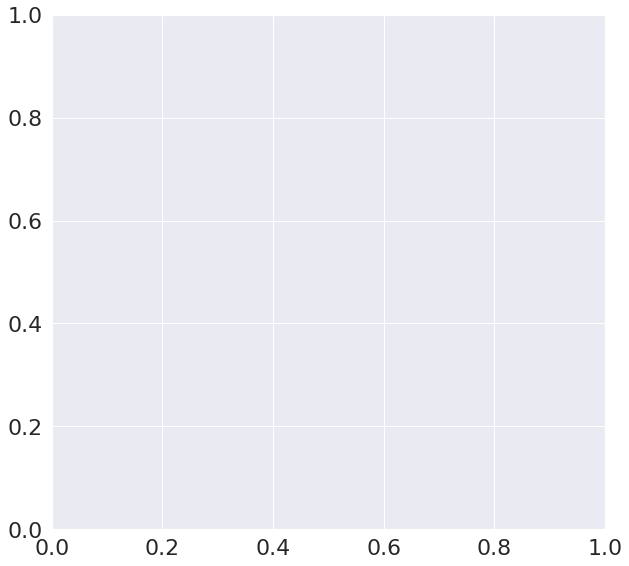

In [ ]:
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(1,4):
    plt.subplot(3,3,i)
    sns.boxplot(y=model_4.columns[i], x='Clusters', data=model_4, palette="colorblind")

In [ ]:
model_4.to_csv('Arrangement.csv')

3D plot of the categories

In [ ]:
fig = px.scatter_3d(model_4, 
                    x='Calories/100g', 
                    y='Price per Volume', 
                    z='Frequency',
                    color='Clusters', 
                    
                    size_max=18,
              symbol='Clusters', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))